# Trees classification using CNN and transfer learning
The goal of the project is to classify if given tree is a pine or an oak, by using a photo of its bark. 

Classifier is based on existing convolutional neural network from keras library: *MobileNet*. This model is trained on large dataset which contains 1000 classes, but by using transfer learning it will be adapted to trees case.

## Install dependencies
Packages used in project:
- numpy
- keras
- scikit-learn
- IPython
- PIL

In [34]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras import models
from keras import optimizers
from keras.metrics import accuracy
from PIL import Image
from IPython.display import display
from IPython.display import Image as _Imgdis
from matplotlib import pyplot as plt

## Load data
Used data contains 199 photos of trees:
- 89 of oak
- 110 of pine

First we'd like to import images into list.

Working with 89 oak and 110 pine images
5 random oak image examples: 


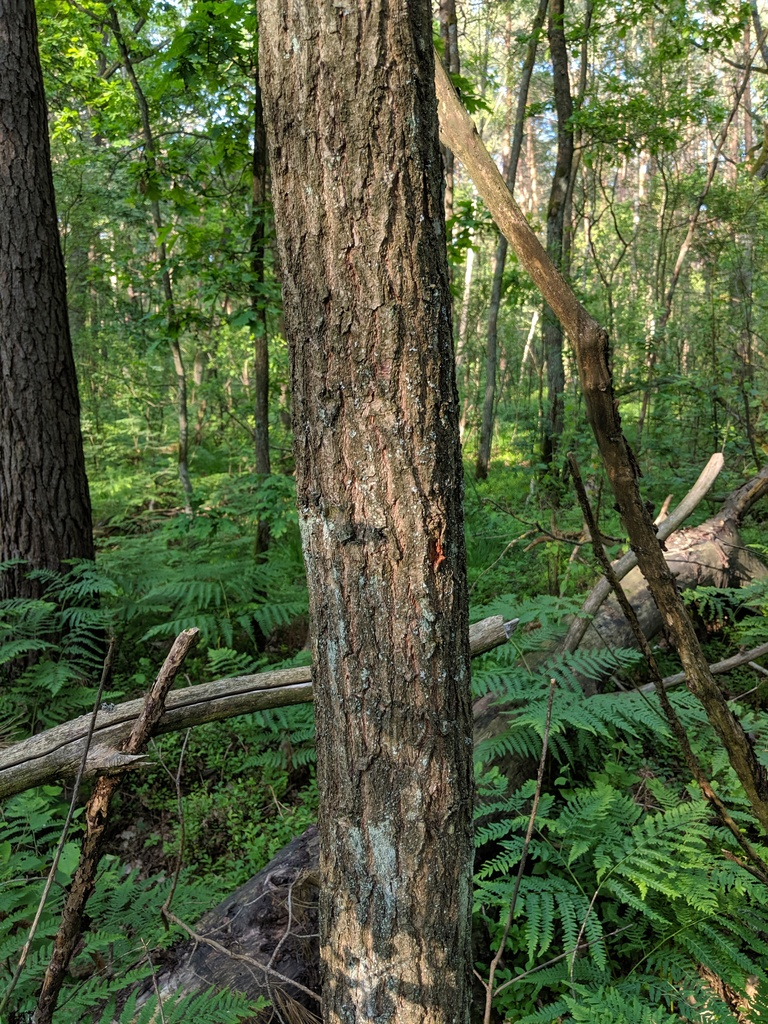

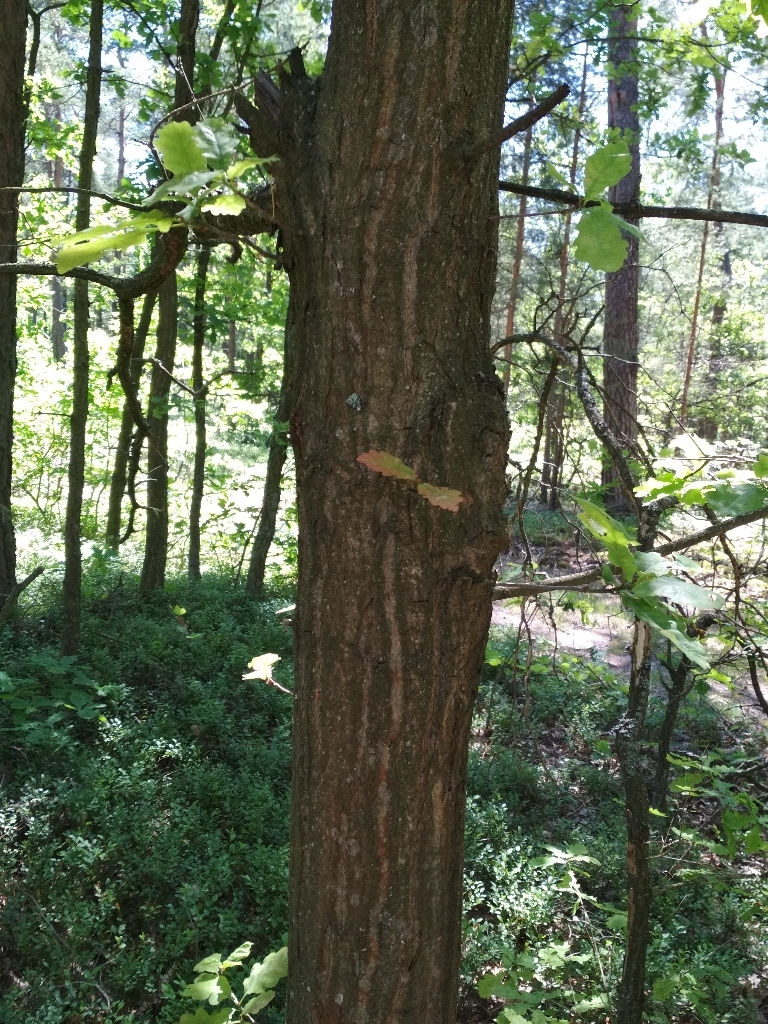

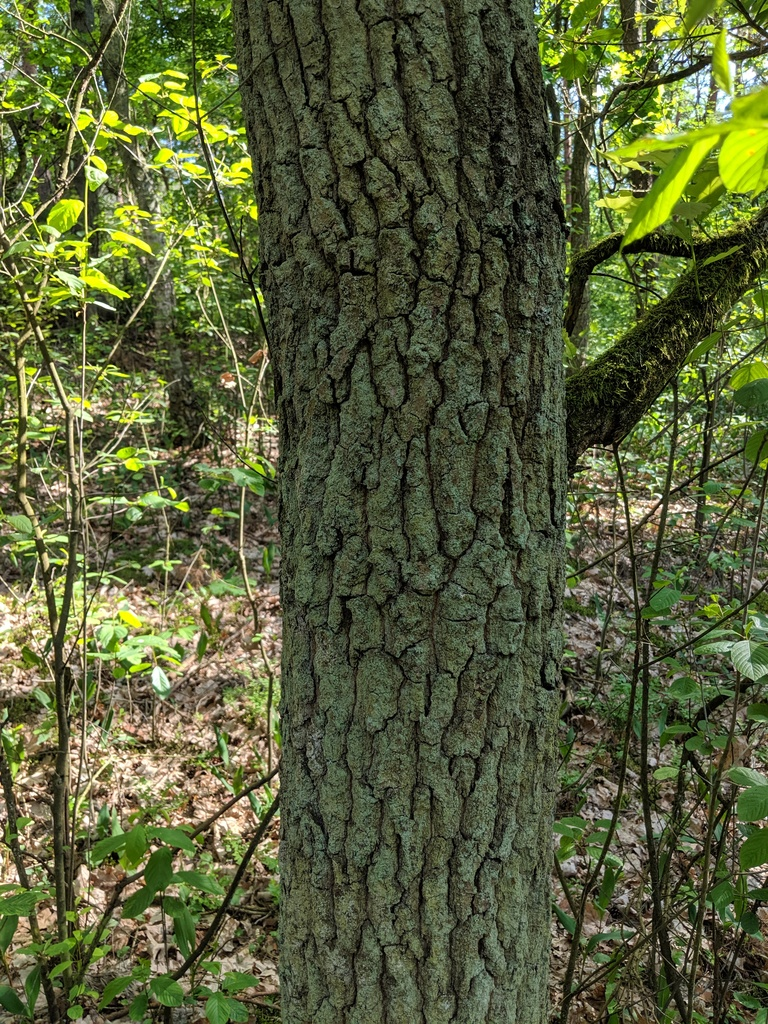

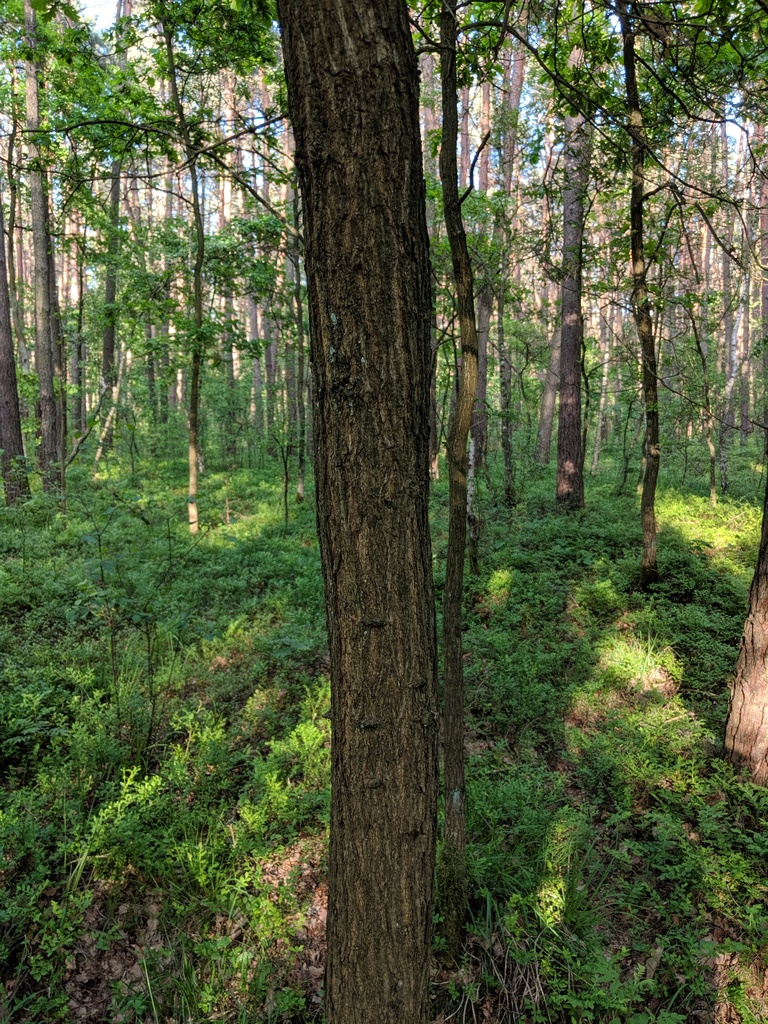

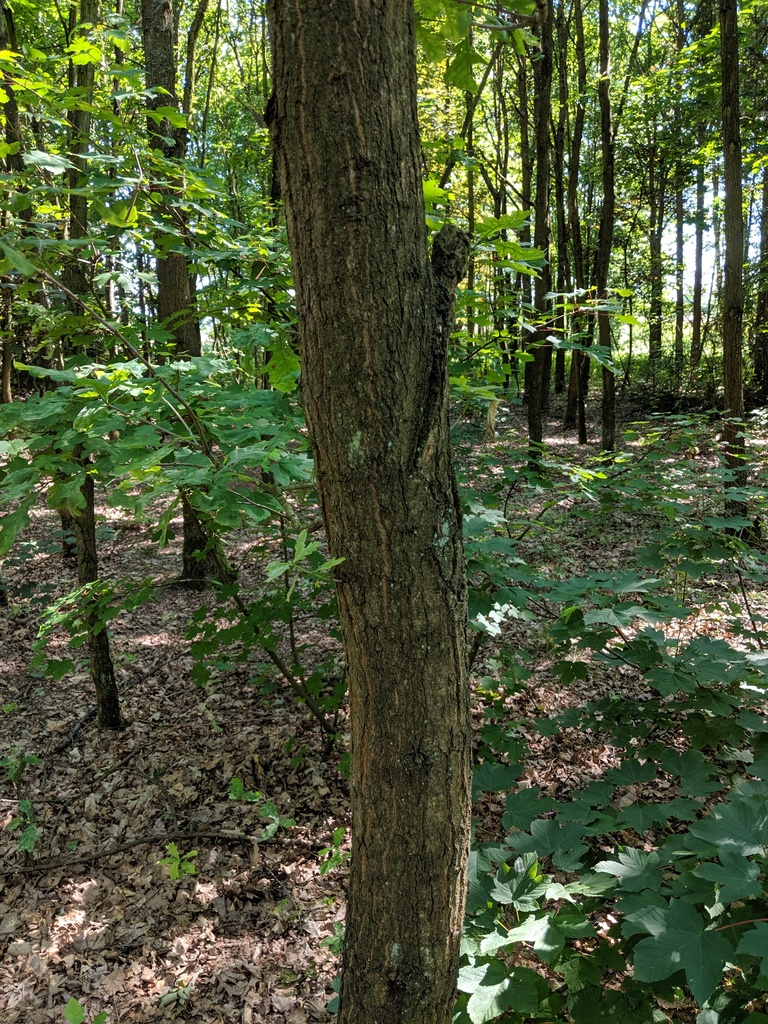

and 5 random pine image examples: 


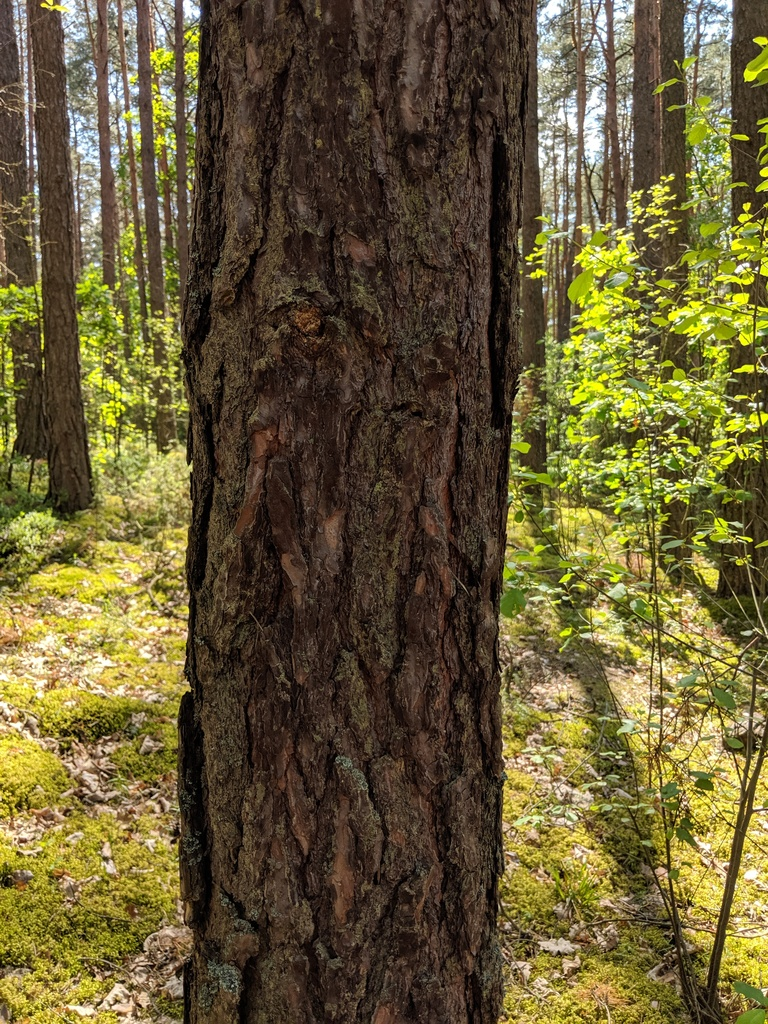

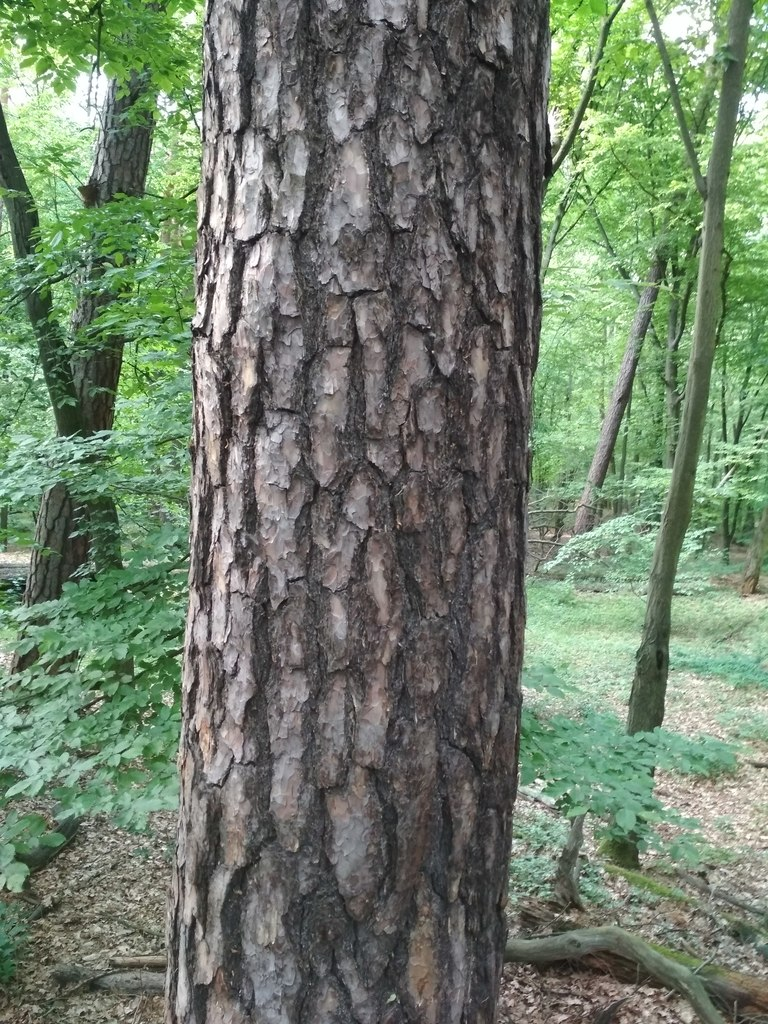

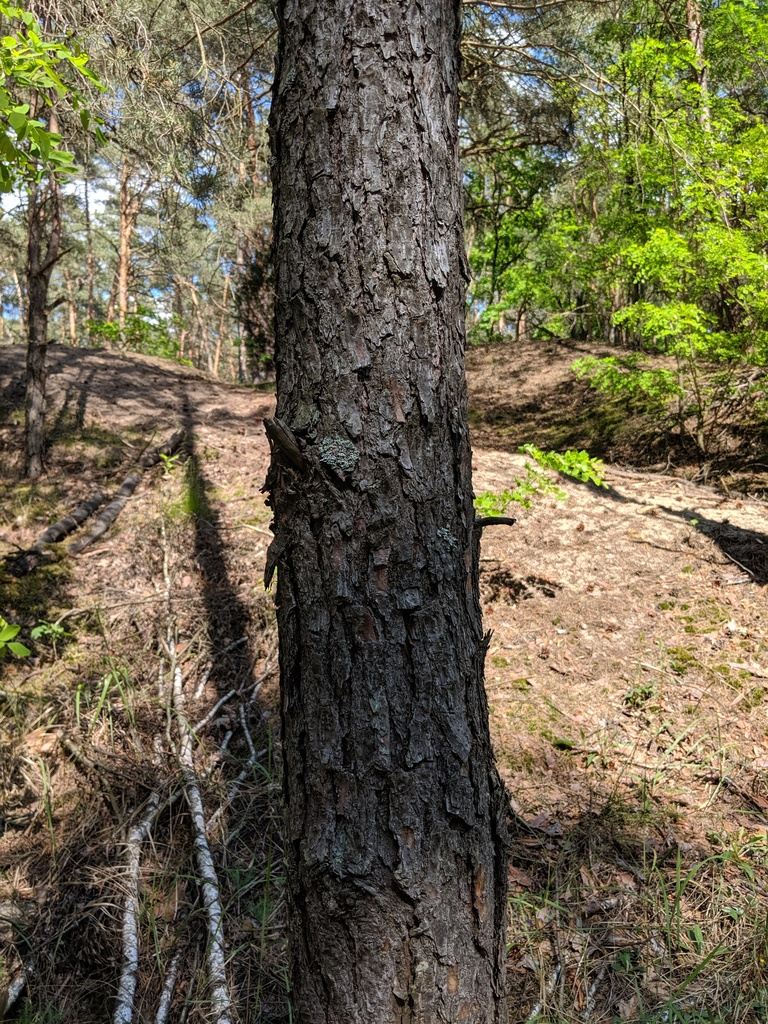

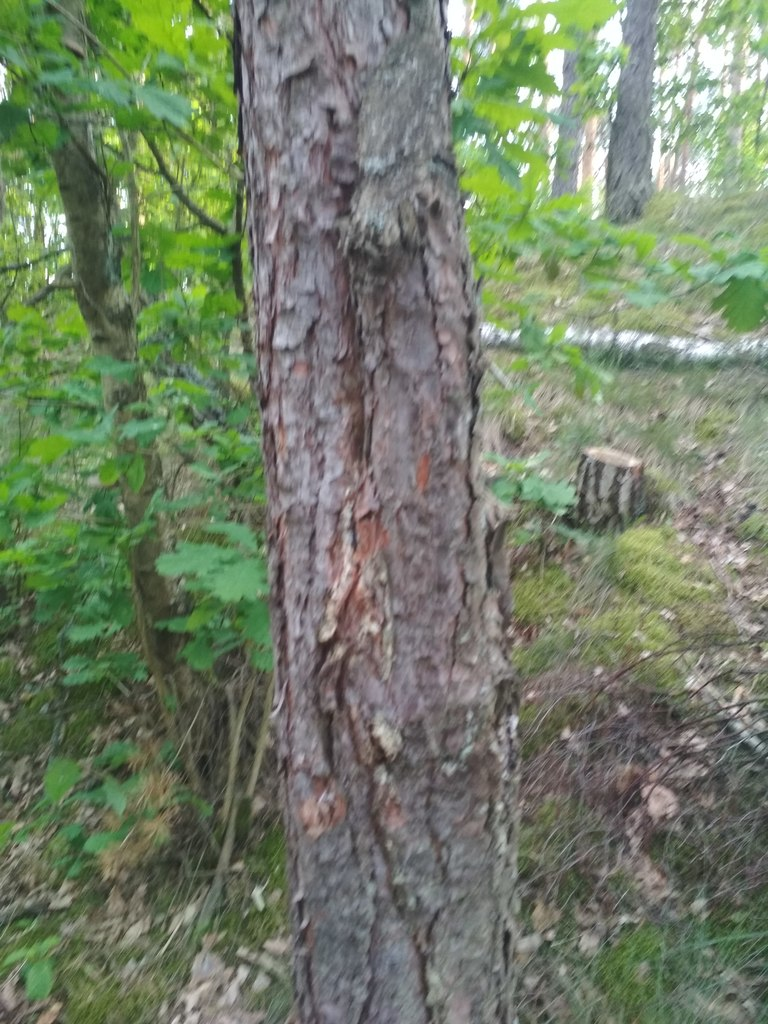

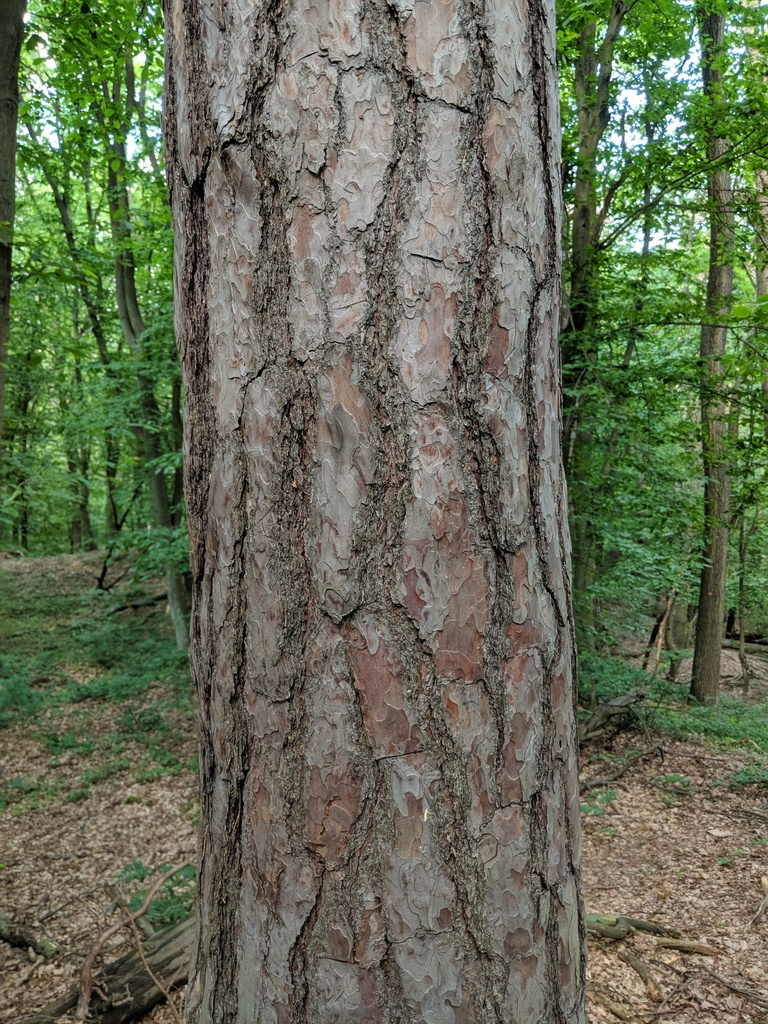

In [2]:
folder_oak = "./data/oak"
imgs_oak = [f for f in os.listdir(folder_oak) if (os.path.isfile(os.path.join(folder_oak, f)) and os.path.splitext(f)[1]=='.jpg')]
folder_pine = "./data/pine"
imgs_pine = [f for f in os.listdir(folder_pine) if (os.path.isfile(os.path.join(folder_pine, f))and os.path.splitext(f)[1]=='.jpg')]
print("Working with {0} oak and {1} pine images".format(len(imgs_oak),len(imgs_pine)))

from random import choice

print("5 random oak image examples: ")
for _ in range(5):
    display(_Imgdis(filename=folder_oak + "/" + imgs_oak[choice(range(len(imgs_oak)))], width=240, height=320))
print("and 5 random pine image examples: ")
for _ in range(5):
    display(_Imgdis(filename=folder_pine + "/" + imgs_pine[choice(range(len(imgs_pine)))], width=240, height=320))

## Prepare data
We have two lists with filenames of oak and pine images. To input them into model, we have to convert them to numerical array. Pictures are in 768 x 1024 resolution. As it would be too much amount of data, images are thumbnailed 3 times.

In [8]:
labels = len(imgs_oak)*['oak'] + len(imgs_pine)*['pine']

In [10]:
def load_photos(imgs, treename, IMG_WIDTH = 768, IMG_HEIGHT = 1024):     
    channels = 3
    dataset = np.ndarray(shape=(len(imgs), IMG_HEIGHT, IMG_WIDTH, channels),
                         dtype=np.float32)

    for i, f in enumerate(imgs):
        img = load_img('./data/' + treename + '/' + f)
        img.thumbnail((IMG_WIDTH, IMG_HEIGHT))
        x = img_to_array(img)
        x = x.reshape((IMG_HEIGHT, IMG_WIDTH, 3))
        dataset[i] = x
    return dataset

In [11]:
img_width = 768//3
img_height = 1024//3

In [12]:
ds_oak = load_photos(imgs_oak, 'oak', IMG_WIDTH = img_width, IMG_HEIGHT = img_height)
ds_pine = load_photos(imgs_pine, 'pine', IMG_WIDTH = img_width, IMG_HEIGHT = img_height)
dataset_non_norm = np.concatenate([ds_oak, ds_pine], axis=0)

The numpy array includes info about every pixel in images. The values are in 0 to 255 range. To put data into model, it's necessary to format it to <0;1> range. Let's do *min-max normalization*: 

In [13]:
dataset = (dataset_non_norm - dataset_non_norm.min())/(dataset_non_norm.max() - dataset_non_norm.min())
dataset[0]

array([[[0.14901961, 0.1882353 , 0.16470589],
        [0.20392157, 0.24705882, 0.2627451 ],
        [0.78431374, 0.8392157 , 0.8666667 ],
        ...,
        [0.56078434, 0.65882355, 0.68235296],
        [0.60784316, 0.7137255 , 0.7019608 ],
        [0.5803922 , 0.6862745 , 0.6431373 ]],

       [[0.16078432, 0.2       , 0.16862746],
        [0.19215687, 0.23529412, 0.24705882],
        [0.654902  , 0.7058824 , 0.7372549 ],
        ...,
        [0.7137255 , 0.81960785, 0.85882354],
        [0.4745098 , 0.6039216 , 0.5686275 ],
        [0.31764707, 0.45490196, 0.35686275]],

       [[0.16862746, 0.21176471, 0.16470589],
        [0.14901961, 0.19607843, 0.19607843],
        [0.45490196, 0.5058824 , 0.53333336],
        ...,
        [0.6862745 , 0.8       , 0.8117647 ],
        [0.32941177, 0.48235294, 0.39215687],
        [0.24705882, 0.42352942, 0.2509804 ]],

       ...,

       [[0.5921569 , 0.58431375, 0.627451  ],
        [0.5647059 , 0.56078434, 0.6       ],
        [0.54901963, 0

## First model
As we have prepared dataset with labels, we can try to do first model. There's no a lot of photos, so accurracy of model may be really poor, and it would be necessary to do some data augmentation. But for the first we are going to work on starting dataset and do only simple split, without cross validation.
### Split data
We do simple split on dataset - for train, validation and test sets.

In [14]:
X_tr, X_test, y_tr, y_test = train_test_split(dataset, labels,
                                                    test_size=0.1, random_state=33)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=1)
print("Train set size: {0}, Validation set size: {1}, Test set size: {2}"
        .format(len(y_tr), len(y_val), len(y_test)))

Train set size: 143, Validation set size: 36, Test set size: 20


We have to remember, that our training output data is provided by the list:

In [15]:
y_tr[:10]

['pine', 'oak', 'oak', 'pine', 'pine', 'pine', 'oak', 'oak', 'pine', 'oak']

To correct that fact, we have to change list of labels to categorical matrix. We have to first correct list of labels into integers before use *to_categorical* from keras.

In [16]:
y_tr = [0 if label=='oak' else 1 for label in y_tr]
y_tr = to_categorical(y_tr)
y_val = [0 if label=='oak' else 1 for label in y_val]
y_val = to_categorical(y_val)
y_test = [0 if label=='oak' else 1 for label in y_test]
y_test = to_categorical(y_test)
y_tr[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### Import pre-trained model
We will use *MobileNet* model from keras library. This model is trained on large dataset with 1000 neurons in last layer, for each class in dataset. Due the fact that we have only 2 classes in our dataset, we will discard this layer by setting property *include_top=False*.

In [17]:
mob_net = MobileNet(weights='imagenet', include_top=False)

c:\users\errry\pycharmprojects\treeclassification\venv\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


We can add last layer with 2 neurons and softmax function.

In [18]:
x = mob_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outs = Dense(2, activation='softmax')(x)

Now we merge this layer with *MobileNet* model.

In [19]:
model = Model(inputs=mob_net.input, outputs=outs)

for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

The model has 90 layers:
- 1 input
- 86 convolutional internal layers
- 1 global average pooling layer to connect network with our final layer
- 1 dense layer that we will train
- 1 output layer

Because we use transfer learning, we don't need to train layers from imported model. We will train only layer which we added:

In [20]:
for layer in model.layers[:87]:
    layer.trainable=False
for layer in model.layers[87:]:
    layer.trainable=True

### Compile and fit model
We can compile model with *Adam* optimizer and use categorical cross entropy as loss function. After that we fit it to our training dataset.

In [21]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_tr, y_tr, batch_size=4, epochs=5, validation_data=(X_val, y_val))

Train on 143 samples, validate on 36 samples
Epoch 1/5
143/143 [==============================] - 25s 175ms/step - loss: 1.4810 - accuracy: 0.5315 - val_loss: 0.5308 - val_accuracy: 0.7500
Epoch 2/5
143/143 [==============================] - 24s 165ms/step - loss: 0.4112 - accuracy: 0.8042 - val_loss: 0.4847 - val_accuracy: 0.6944
Epoch 3/5
143/143 [==============================] - 23s 161ms/step - loss: 0.4139 - accuracy: 0.8182 - val_loss: 0.6624 - val_accuracy: 0.6389
Epoch 4/5
143/143 [==============================] - 23s 160ms/step - loss: 0.4103 - accuracy: 0.8112 - val_loss: 0.5580 - val_accuracy: 0.6667
Epoch 5/5
143/143 [==============================] - 23s 164ms/step - loss: 0.2877 - accuracy: 0.8811 - val_loss: 0.5248 - val_accuracy: 0.6944


Finally, we have fited our first model. It was fited on data splited into one training set of 143 photos from 199.

We can save weights of the model:

In [22]:
model.save_weights('./model_weights/mod_1.h5')

### Predictions of first model
Let's use model to predict classes of test set.

In [23]:
preds = model.predict(X_test, batch_size=4)

In [24]:
preds = np.round(preds, decimals=0)
preds

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [25]:
y_test == preds

array([[False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False]])

In [26]:
np.mean(y_test == preds)

0.65

Now we have a good point of reference, to do next, better model.
## Evaluation of the first model
For the first we will add layers into model, we also train deeper layers from model - we start training from 81 layer, beside 87.

In [28]:
x = mob_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
outs2 = Dense(2,activation='softmax')(x) 

model2 = Model(inputs=mob_net.input, outputs=outs2)

for i, layer in enumerate(model2.layers):
    print(i, layer.name)
    
for layer in model2.layers[:81]:
    layer.trainable=False
for layer in model2.layers[81:]:
    layer.trainable=True

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

Now model is constructed with 2 dense layers with relu activation function. As in the previous model, only new layers will be trained.

In [37]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

base_history2 = model2.fit(X_tr, y_tr, batch_size=4, epochs=5, validation_data=(X_val, y_val))

Train on 143 samples, validate on 36 samples
Epoch 1/5
143/143 [==============================] - 32s 221ms/step - loss: 0.3731 - accuracy: 0.8671 - val_loss: 0.9201 - val_accuracy: 0.4167
Epoch 2/5
143/143 [==============================] - 29s 205ms/step - loss: 0.2526 - accuracy: 0.9161 - val_loss: 0.3554 - val_accuracy: 0.8333
Epoch 3/5
143/143 [==============================] - 30s 210ms/step - loss: 0.2499 - accuracy: 0.9021 - val_loss: 0.4546 - val_accuracy: 0.8056
Epoch 4/5
143/143 [==============================] - 28s 194ms/step - loss: 0.2149 - accuracy: 0.9510 - val_loss: 0.6371 - val_accuracy: 0.6667
Epoch 5/5
143/143 [==============================] - 29s 201ms/step - loss: 0.2652 - accuracy: 0.8462 - val_loss: 0.3663 - val_accuracy: 0.8611


In [42]:
def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, 5 + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

In [40]:
np.argmin(base_history2.history['val_loss']) + 1

2

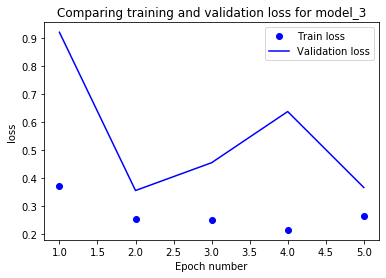

In [43]:
eval_metric(model2, base_history2, 'loss')

In [46]:
model2.save_weights('./model_weights/mod_2.h5')

In [44]:
preds2 = model2.predict(X_test,batch_size=4)
preds2 = np.round(preds2, decimals=0)
preds2

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [45]:
np.mean(y_test == preds2)

0.85

Change that we have made - 2 new layers added to model

Let's head to next improvement: data augmentation to increase training dataset.

## Second try: Data Augmentation
Our dataset is rather small, it contains only two hundreds of pictures. As we saw some examples at the begin of the notebook, the pictures are quite similar - each of them is taken vertically and from similar distance.

As the pictures are taken vertically, the chosen augmentation operations are:
- random horizontal shift (50 pixels to right or left)
- random rotation (in range of 90 degrees)
- random horizontal flip
- random zoom (between 0.5 and 1.0) 


In [47]:
def generate_aug_photos(samples, treename, imgs_count, aug_index):
    ds = np.ndarray(shape=(imgs_count, samples.shape[1], samples.shape[2], 3),
                         dtype=np.float32)
    datagen2 = ImageDataGenerator(width_shift_range=[-50,50], rotation_range=90, horizontal_flip=True,
                                  zoom_range=[0.5,1.0], rescale=1.0/255.0)
    datagen2.fit(samples)
    for batch in datagen2.flow(samples, batch_size=imgs_count):
        for i in range(imgs_count):
            ds[i] = batch[i]
            str_file = 'data/aug/'+ treename + '/aug_' +str(aug_index)+'_'  + str(i)+'.jpg'
            if os.path.isfile(str_file):
                os.remove(str_file) 
            plt.imsave(str_file, batch[i])
        break
    return ds

After creating function to generate augmented photos, we will call it 3 times for each class to generate 3 times more pictures for every class.

In [48]:
ds_oak2 = load_photos(imgs_oak, 'oak', IMG_WIDTH=768//3, IMG_HEIGHT=1024//3)
ds_pine2 = load_photos(imgs_pine, 'pine', IMG_WIDTH=768//3, IMG_HEIGHT=1024//3)
  
tmp1 = generate_aug_photos(ds_oak2, 'oak', 89, 1)
tmp2 = generate_aug_photos(ds_oak2, 'oak', 89, 2)
tmp3 = generate_aug_photos(ds_oak2, 'oak', 89, 3)
ds_oak2_aug = np.concatenate([tmp1,tmp2,tmp3], axis=0)
tmp1 = generate_aug_photos(ds_pine2, 'pine', 110, 1)
tmp2 = generate_aug_photos(ds_pine2, 'pine', 110, 2)
tmp3 = generate_aug_photos(ds_pine2, 'pine', 110, 3)
ds_pine2_aug = np.concatenate([tmp1,tmp2,tmp3], axis=0)

In [49]:
del tmp1, tmp2, tmp3

Let's look at 5 random augmented images from each class.

Working with 356 oak and 440 pine augmented images
5 random oak augmented image examples: 


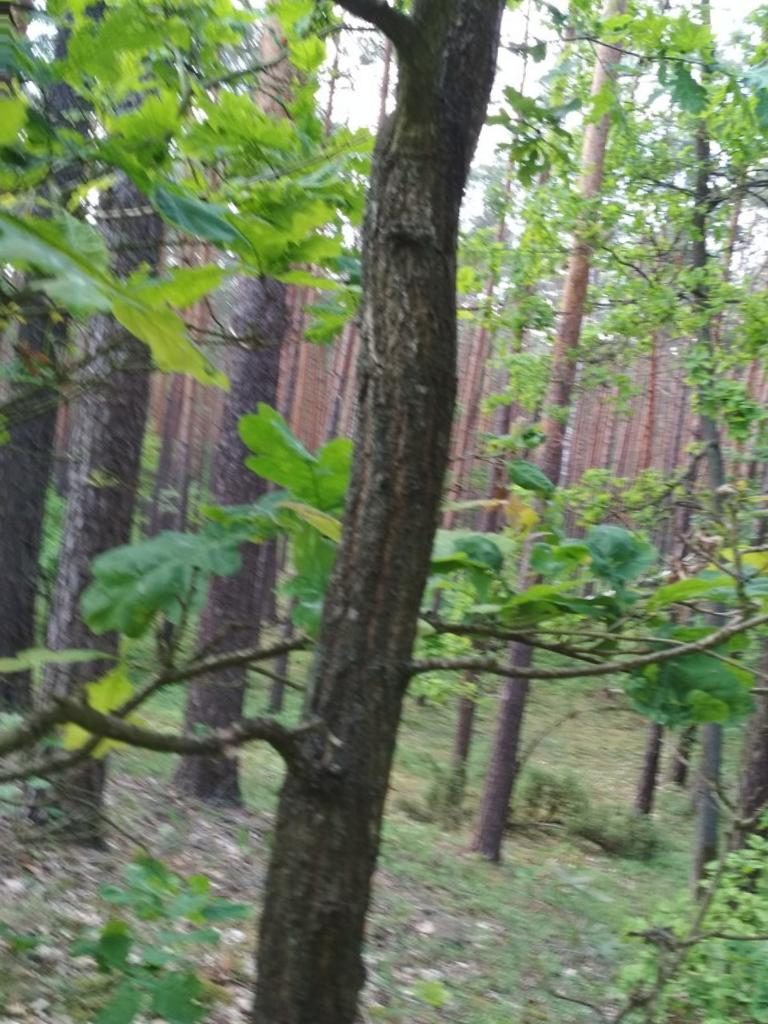

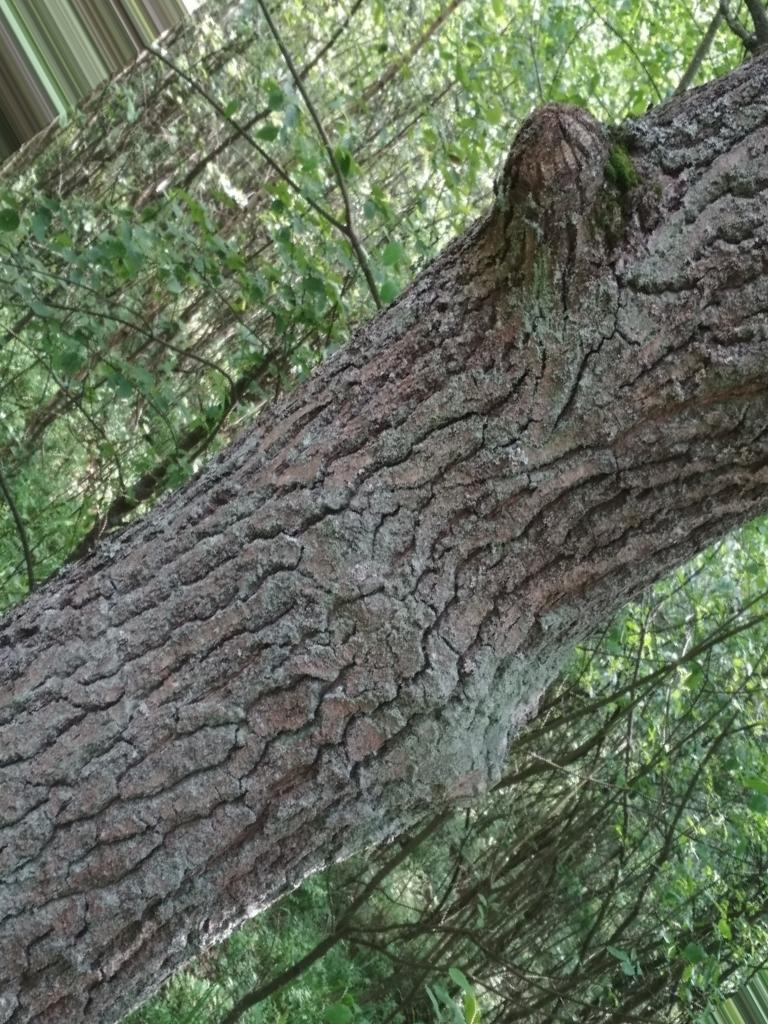

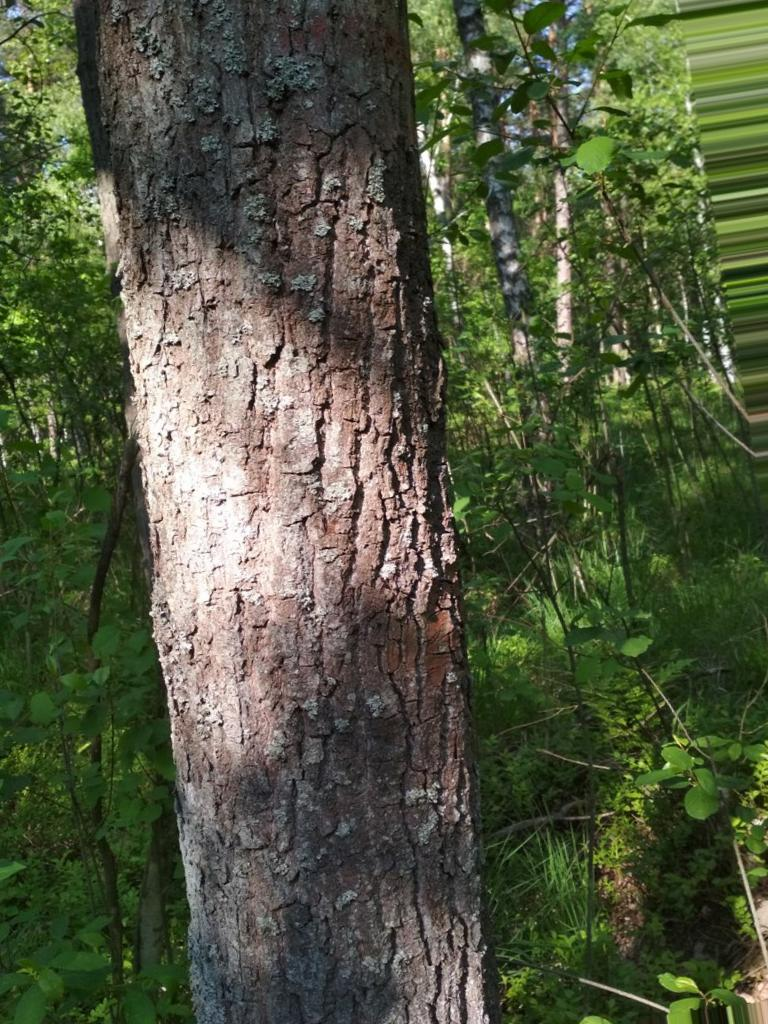

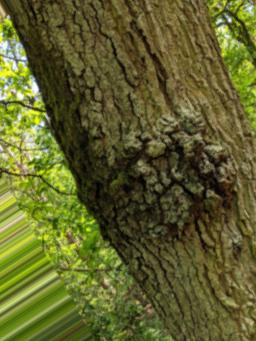

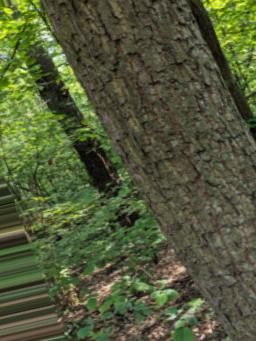

and 5 random pine augmented image examples: 


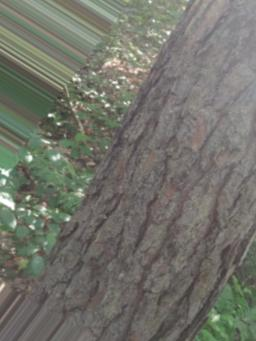

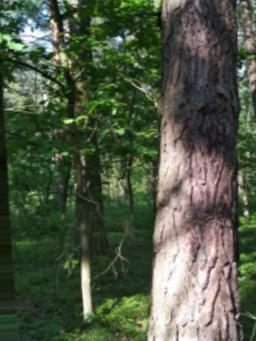

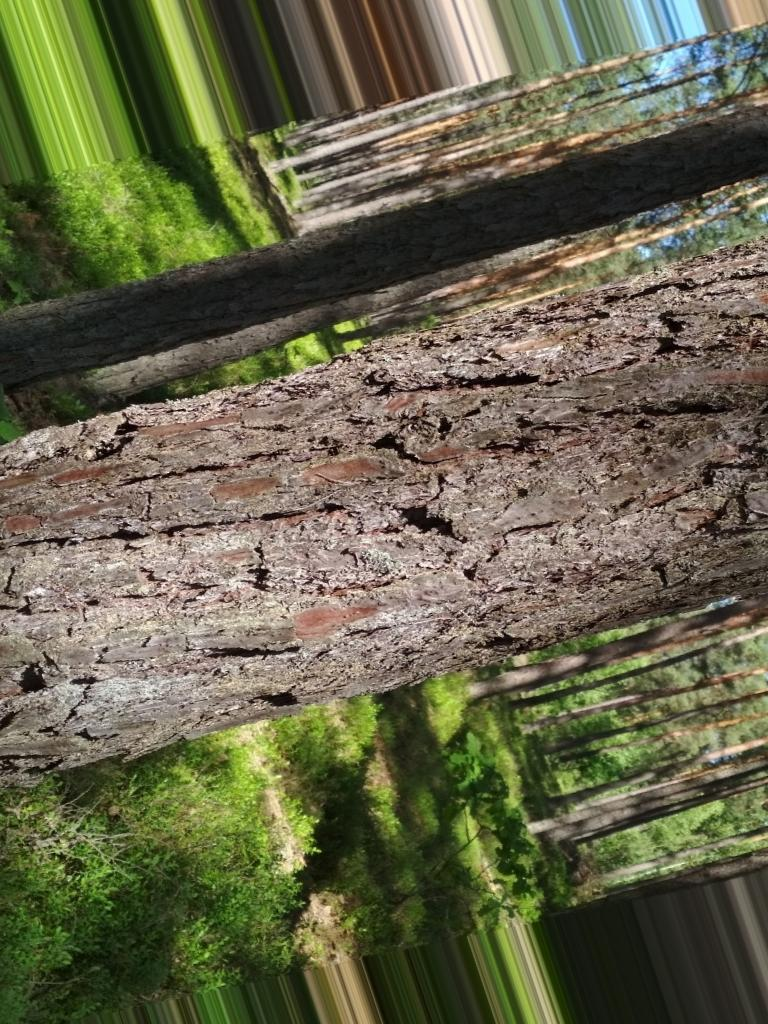

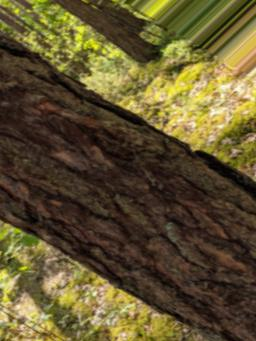

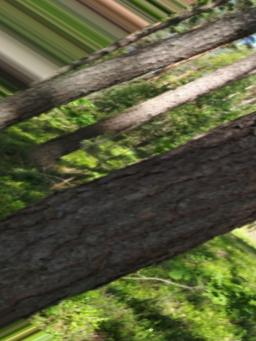

In [50]:
folder_oak_aug = "./data/aug/oak"
imgs_oak_aug = [f for f in os.listdir(folder_oak_aug) if (os.path.isfile(os.path.join(folder_oak_aug, f)) and os.path.splitext(f)[1]=='.jpg')]
folder_pine_aug = "./data/aug/pine"
imgs_pine_aug = [f for f in os.listdir(folder_pine_aug) if (os.path.isfile(os.path.join(folder_pine_aug, f))and os.path.splitext(f)[1]=='.jpg')]
print("Working with {0} oak and {1} pine augmented images".format(len(imgs_oak_aug),len(imgs_pine_aug)))

print("5 random oak augmented image examples: ")
for _ in range(5):
    display(_Imgdis(filename=folder_oak_aug + "/" + imgs_oak_aug[choice(range(len(imgs_oak_aug)))], width=240, height=320))
print("and 5 random pine augmented image examples: ")
for _ in range(5):
    display(_Imgdis(filename=folder_pine_aug + "/" + imgs_pine_aug[choice(range(len(imgs_pine_aug)))], width=240, height=320))

### Train model on new data
Now we can load our new data and train model on it

In [51]:
dataset2 = np.concatenate([ds_oak2,
                           ds_oak2_aug,
                           ds_pine2,
                           ds_pine2_aug], axis=0)

In [52]:
labels2 = 356*['oak'] + 440*['pine']  

labels2 = [0 if label=='oak' else 1 for label in labels2]
labels2 = to_categorical(labels2)

Quick normalization on dataset:

In [53]:
dataset2 = (dataset2 - dataset2.min())/(dataset2.max() - dataset2.min())
dataset2[0]

array([[[0.14901961, 0.1882353 , 0.16470589],
        [0.20392157, 0.24705882, 0.2627451 ],
        [0.78431374, 0.8392157 , 0.8666667 ],
        ...,
        [0.56078434, 0.65882355, 0.68235296],
        [0.60784316, 0.7137255 , 0.7019608 ],
        [0.5803922 , 0.6862745 , 0.6431373 ]],

       [[0.16078432, 0.2       , 0.16862746],
        [0.19215687, 0.23529412, 0.24705882],
        [0.654902  , 0.7058824 , 0.7372549 ],
        ...,
        [0.7137255 , 0.81960785, 0.85882354],
        [0.4745098 , 0.6039216 , 0.5686275 ],
        [0.31764707, 0.45490196, 0.35686275]],

       [[0.16862746, 0.21176471, 0.16470589],
        [0.14901961, 0.19607843, 0.19607843],
        [0.45490196, 0.5058824 , 0.53333336],
        ...,
        [0.6862745 , 0.8       , 0.8117647 ],
        [0.32941177, 0.48235294, 0.39215687],
        [0.24705882, 0.42352942, 0.2509804 ]],

       ...,

       [[0.5921569 , 0.58431375, 0.627451  ],
        [0.5647059 , 0.56078434, 0.6       ],
        [0.54901963, 0

In [54]:
X_tr2, X_test2, y_tr2, y_test2 = train_test_split(dataset2, labels2, test_size=0.1, random_state=33)
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_tr2, y_tr2, test_size=0.2, random_state=33)

print("Train set size: {0}, Validation set size: {1}, Test set size: {2}"
        .format(len(y_tr2), len(y_val2), len(y_test2)))

Train set size: 572, Validation set size: 144, Test set size: 80


In [55]:
model3 = Model(inputs=mob_net.input, outputs=outs2)
   
for layer in model2.layers[:81]:
    layer.trainable=False
for layer in model2.layers[81:]:
    layer.trainable=True
model3.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
base_hist3 = model3.fit(X_tr2, y_tr2, batch_size=4, epochs=5, validation_data=(X_val2, y_val2))

Train on 572 samples, validate on 144 samples
Epoch 1/5
572/572 [==============================] - 121s 211ms/step - loss: 0.6352 - accuracy: 0.6364 - val_loss: 1.4112 - val_accuracy: 0.4861
Epoch 2/5
572/572 [==============================] - 123s 215ms/step - loss: 0.5863 - accuracy: 0.7028 - val_loss: 0.8930 - val_accuracy: 0.5208
Epoch 3/5
572/572 [==============================] - 120s 210ms/step - loss: 0.6213 - accuracy: 0.6713 - val_loss: 0.9731 - val_accuracy: 0.4861
Epoch 4/5
572/572 [==============================] - 115s 201ms/step - loss: 0.5465 - accuracy: 0.7150 - val_loss: 0.6428 - val_accuracy: 0.5625
Epoch 5/5
572/572 [==============================] - 123s 214ms/step - loss: 0.5494 - accuracy: 0.7238 - val_loss: 1.0475 - val_accuracy: 0.5000


Optimal epoch in model: 4


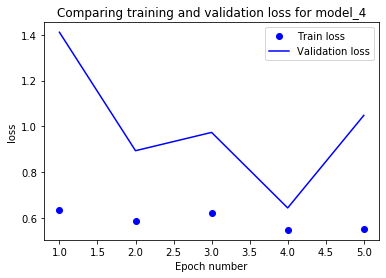

In [57]:
print("Optimal epoch in model: {0}".format(np.argmin(base_hist3.history['val_loss']) + 1))
eval_metric(model3, base_hist3, 'loss')

In [58]:
model3.save_weights('./model_weights/mod_3.h5')

In [59]:
preds3 = model3.predict(X_test2,batch_size=4)
preds3 = np.round(preds3, decimals=0)
preds3[:15]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [60]:
np.mean(y_test2 == preds3)

0.6375

In [61]:
model3.evaluate(X_test2, y_test2, batch_size=2)

80/80 [==============================] - 11s 137ms/step


[0.7746501794084907, 0.637499988079071]

## Testing changes in layers
To check if our model can be improved, we will test modifications in our model, based on MobileNet.

In [64]:
x = mob_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
x = Dense(512,activation='relu')(x)
outs3 = Dense(2,activation='softmax')(x) 

model4 = Model(inputs=mob_net.input, outputs=outs3)
    
for layer in model4.layers[:81]:
    layer.trainable=False
for layer in model4.layers[81:]:
    layer.trainable=True

In [65]:
model4.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
base_hist4 = model4.fit(X_tr2, y_tr2, batch_size=4, epochs=5, validation_data=(X_val2, y_val2))

Train on 572 samples, validate on 144 samples
Epoch 1/5
572/572 [==============================] - 126s 220ms/step - loss: 0.6469 - accuracy: 0.6818 - val_loss: 0.6619 - val_accuracy: 0.6181
Epoch 2/5
572/572 [==============================] - 118s 207ms/step - loss: 0.5725 - accuracy: 0.7255 - val_loss: 0.6978 - val_accuracy: 0.5208
Epoch 3/5
572/572 [==============================] - 121s 211ms/step - loss: 0.5684 - accuracy: 0.7255 - val_loss: 0.6807 - val_accuracy: 0.5139
Epoch 4/5
572/572 [==============================] - 126s 220ms/step - loss: 0.5424 - accuracy: 0.7150 - val_loss: 1.0884 - val_accuracy: 0.5000
Epoch 5/5
572/572 [==============================] - 128s 224ms/step - loss: 0.4979 - accuracy: 0.7605 - val_loss: 0.6721 - val_accuracy: 0.5486


Optimal epoch in model: 1


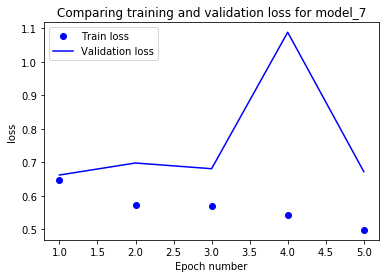

In [66]:
print("Optimal epoch in model: {0}".format(np.argmin(base_hist4.history['val_loss']) + 1))
eval_metric(model4, base_hist4, 'loss')

In [67]:
model4.save_weights('./model_weights/mod_4.h5')

In [68]:
preds4 = model4.predict(X_test2, batch_size=4)
preds4 = np.round(preds4, decimals=0)
print(np.mean(y_test2 == preds4))
model4.evaluate(X_test2, y_test2, batch_size=2)

0.4
80/80 [==============================] - 13s 158ms/step


[0.7515892002731561, 0.4000000059604645]

# Another base pre-trained model - *InceptionV3*
Now let's try another base CNN model instead of *MobileNet*, now it's time for *InceptionV3*:

In [69]:
from keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(weights='imagenet', include_top=False)

In [70]:
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outs4 = Dense(2, activation='softmax')(x)

model5 = Model(inputs=inception.input, outputs=outs4)

for i, layer in enumerate(model5.layers):
    print(i, layer.name)

0 input_2
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [71]:
for layer in model5.layers[:311]:
    layer.trainable=False
for layer in model5.layers[311:]:
    layer.trainable=True

In [72]:
model5.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

base_hist5 = model5.fit(X_tr2, y_tr2, batch_size=4, epochs=5, validation_data=(X_val2, y_val2))

Train on 572 samples, validate on 144 samples
Epoch 1/5
572/572 [==============================] - 163s 286ms/step - loss: 1.0148 - accuracy: 0.5612 - val_loss: 0.7070 - val_accuracy: 0.4931
Epoch 2/5
572/572 [==============================] - 158s 275ms/step - loss: 0.7087 - accuracy: 0.5769 - val_loss: 0.6872 - val_accuracy: 0.4931
Epoch 3/5
572/572 [==============================] - 163s 285ms/step - loss: 0.6682 - accuracy: 0.6206 - val_loss: 0.6839 - val_accuracy: 0.4931
Epoch 4/5
572/572 [==============================] - 162s 284ms/step - loss: 0.6797 - accuracy: 0.5559 - val_loss: 0.6930 - val_accuracy: 0.5278
Epoch 5/5
572/572 [==============================] - 150s 262ms/step - loss: 0.6770 - accuracy: 0.5455 - val_loss: 0.7193 - val_accuracy: 0.4792


Optimal epoch in model: 3


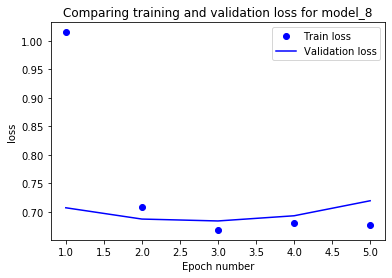

In [73]:
print("Optimal epoch in model: {0}".format(np.argmin(base_hist5.history['val_loss']) + 1))
eval_metric(model5, base_hist5, 'loss')

In [74]:
model5.save_weights('./model_weights/mod_5.h5')

In [75]:
preds5 = model5.predict(X_test2,batch_size=4)
preds5 = np.round(preds5, decimals=0)
print(np.mean(y_test2 == preds5))
model5.evaluate(X_test2, y_test2, batch_size=2)

0.6
80/80 [==============================] - 18s 224ms/step


[0.667520160228014, 0.6000000238418579]

Now let's try more dense layers in model and train more deep layers in base *InceptionV3* model:

In [76]:
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
x = Dense(512,activation='relu')(x)
outs5 = Dense(2, activation='softmax')(x)

model6 = Model(inputs=inception.input, outputs=outs5)

for layer in model6.layers[:298]:
    layer.trainable=False
for layer in model6.layers[298:]:
    layer.trainable=True

In [77]:
model6.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

base_hist6 = model6.fit(X_tr2, y_tr2, batch_size=4, epochs=5, validation_data=(X_val2, y_val2))

Train on 572 samples, validate on 144 samples
Epoch 1/5
572/572 [==============================] - 205s 359ms/step - loss: 0.7256 - accuracy: 0.5559 - val_loss: 0.6940 - val_accuracy: 0.4792
Epoch 2/5
572/572 [==============================] - 205s 358ms/step - loss: 0.6873 - accuracy: 0.5577 - val_loss: 0.7016 - val_accuracy: 0.4792
Epoch 3/5
572/572 [==============================] - 209s 365ms/step - loss: 0.6799 - accuracy: 0.5577 - val_loss: 0.6994 - val_accuracy: 0.4792
Epoch 4/5
572/572 [==============================] - 201s 352ms/step - loss: 0.6870 - accuracy: 0.5647 - val_loss: 0.7045 - val_accuracy: 0.4792
Epoch 5/5
572/572 [==============================] - 204s 356ms/step - loss: 0.6785 - accuracy: 0.5787 - val_loss: 0.6959 - val_accuracy: 0.4792


Optimal epoch in model: 1


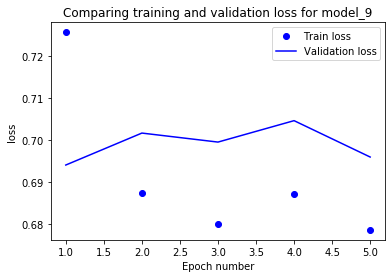

In [78]:
print("Optimal epoch in model: {0}".format(np.argmin(base_hist6.history['val_loss']) + 1))
eval_metric(model6, base_hist6, 'loss')

In [79]:
model6.save_weights('./model_weights/mod_6.h5')

In [80]:
preds6 = model6.predict(X_test2,batch_size=4)
preds6 = np.round(preds6, decimals=0)
print(np.mean(y_test2 == preds6))
model6.evaluate(X_test2, y_test2, batch_size=2)

0.6
80/80 [==============================] - 20s 246ms/step


[0.6854909807443619, 0.6000000238418579]